In [45]:
%load_ext autoreload
%autoreload 4
%config InlineBackend.figure_format = 'retina'

import collections
import copy
import pprint
import typing as tp
import uuid

import networkx as nx
import numpy as np
from scipy.optimize import linprog

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
class CoffmanGrahamLayout:
    def __call__(
        self, dag: nx.DiGraph, max_width: tp.Optional[float] = None
    ) -> tp.Dict[tp.Hashable, tp.Tuple[float, float]]:
        _dag = nx.algorithms.dag.transitive_reduction(dag)
        node_to_topsort_label = self._sort_nodes_topologically(_dag)
        if max_width is not None:
            topsorted_nodes = self._get_topsorted_node_list(
                node_to_topsort_label
            )
            node_to_layer, layers = (
                self._distribute_nodes_over_fixed_width_layers(
                    dag=_dag,
                    topsorted_nodes=topsorted_nodes, 
                    max_width=max_width
                )
            )
        else:
            node_to_layer, layers = (
                self._distribute_nodes_over_layers_minimizing_dummies(
                    dag=_dag,
                    node_to_topsort_label=node_to_topsort_label, 
                )
            )
        _dag, layers_w_dummies = self._add_dummy_nodes(
            dag=_dag,
            layers=layers,
            node_to_layer=node_to_layer
        )
        layout = self._get_layout(layers=layers_w_dummies)
        self._draw_dag(
            dag=_dag,
            layout=layout,
            axis_type='on',
            node_size=2000,
            font_size=20,
            with_labels=True
        )
        
    @staticmethod
    def _sort_nodes_topologically(dag: nx.DiGraph) -> tp.List[tp.Hashable]:
        node_to_topsort_label: tp.Dict[tp.Hashable, int] = dict()
        nodes_wo_label: tp.Set[tp.Hashable] = set(dag.nodes())
        
        for next_label in range(dag.number_of_nodes()):
            min_parent_labels_set = [float('inf')]
            argmin_node = None
            
            for node in nodes_wo_label:
                parents_labels_set = sorted(
                    [
                        node_to_topsort_label.get(parent, float('inf')) 
                        for parent in dag.predecessors(node) 
                    ], 
                    reverse=True
                )
                if parents_labels_set < min_parent_labels_set:
                    min_parent_labels_set = parents_labels_set
                    argmin_node = node
            
            assert argmin_node is not None
            node_to_topsort_label[argmin_node] = next_label
            nodes_wo_label.remove(argmin_node)
            
        return node_to_topsort_label
    
    
    @staticmethod
    def _get_topsorted_node_list(
        node_to_topsort_label: tp.Dict[tp.Hashable, int]
    ) -> tp.List[tp.Hashable]:
        return [
            node 
            for node, label in sorted(
                node_to_topsort_label.items(),
                key=lambda p: p[1]
            )
        ]
    
    @staticmethod
    def _distribute_nodes_over_layers_minimizing_dummies(
        dag: nx.DiGraph, 
        node_to_topsort_label: tp.List[tp.Hashable]
    ) -> tp.Tuple[
        tp.Dict[tp.Hashable, int],
        tp.List[tp.List[tp.Hashable]]
    ]:
        n_nodes = dag.number_of_nodes()
        boundaries = [(0, None) for i in range(n_nodes)]
        A = []
        b = []
        c = np.zeros(n_nodes)

        for source, sink in dag.edges():
            source_label = node_to_topsort_label[source]
            sink_label = node_to_topsort_label[sink]
            A.append(np.zeros(n_nodes))
            A[-1][source_label] = -1
            A[-1][sink_label] = 1
            b.append(-1)
            c[source_label] += 1
            c[sink_label] -= 1

        linprog_layer_assignment = linprog(
            c, A_ub=A, b_ub=b, bounds=boundaries
        ).x
        node_to_linprog_layer: tp.Dict[tp.Hashable, float] = {
            node: linprog_layer_assignment[topsort_label]
            for node, topsort_label in node_to_topsort_label.items()
        }
        
        topsorted_nodes = CoffmanGrahamLayout._get_topsorted_node_list(
            node_to_topsort_label
        )
        node_to_layer: tp.Dict[tp.Hashable, int] = dict()
        for node in reversed(topsorted_nodes):
            linprog_layer = node_to_linprog_layer[node]
            placement_layer = -1
            for child in dag.successors(node):
                placement_layer = max(
                    placement_layer, 
                    node_to_layer[child] + 1
                )
            if placement_layer == -1:
                placement_layer = int(np.floor(linprog_layer))
            node_to_layer[node] = placement_layer
                    
        layers: tp.List[tp.List[tp.Hashable]] = [
            [] for _ in range(max(node_to_layer.values()) + 1)
        ]
        for node, layer in node_to_layer.items():
            layers[layer].append(node)
        return node_to_layer, layers
        
    @staticmethod
    def _distribute_nodes_over_fixed_width_layers(
        dag: nx.DiGraph, 
        topsorted_nodes: tp.List[tp.Hashable], 
        max_width: int
    ) -> tp.Tuple[
        tp.Dict[tp.Hashable, int],
        tp.List[tp.List[tp.Hashable]]
    ]:
        
        layers: tp.List[tp.List[tp.Hashable]] = []
        node_to_layer: tp.Dict[tp.Hashable, int] = dict()

        for node in reversed(topsorted_nodes):
            placement_layer = 0
            for child in dag.successors(node):
                placement_layer = max(
                    placement_layer, 
                    node_to_layer[child] + 1
                )
            
            while (
                placement_layer < len(layers) 
                and len(layers[placement_layer]) == max_width
            ):
                placement_layer += 1
            
            if placement_layer >= len(layers):
                layers.append([])
            layers[placement_layer].append(node)
            node_to_layer[node] = placement_layer
            
        return node_to_layer, layers
    
    @staticmethod
    def _add_dummy_nodes(
        dag: nx.DiGraph, 
        layers: tp.List[tp.List[tp.Hashable]],
        node_to_layer: tp.Dict[tp.Hashable, int]
    ) -> tp.List[tp.List[tp.Hashable]]:
        
        dag_w_dummies = nx.DiGraph()
        dag_w_dummies.add_nodes_from(dag)
        layers_w_dummies = layers.copy()
        n_dummies: int = 0
        
        for edge in dag.edges():
            
            source, sink = edge
            source_layer = node_to_layer[source]
            sink_layer = node_to_layer[sink]
            
            assert source_layer >= sink_layer
            
            margin = source_layer - sink_layer
            if margin == 1:
                dag_w_dummies.add_edge(source, sink)
                continue
                
            dummy_nodes = []
            layer = source_layer - 1
            for _ in range(margin - 1):
                dummy_node = f'#{n_dummies}'
                dummy_nodes.append(dummy_node)
                layers_w_dummies[layer].append(dummy_node)
                n_dummies += 1
            dag_w_dummies.add_nodes_from(dummy_nodes)
            
            dummy_path = [source] + dummy_nodes + [sink]
            
            for dummy_source, dummy_sink in zip(dummy_path, dummy_path[1:]):
                dag_w_dummies.add_edge(dummy_source, dummy_sink)
                
        return dag_w_dummies, layers_w_dummies
    
    @staticmethod
    def _get_layout(
        layers: tp.List[tp.List[tp.Hashable]]
    ) -> tp.Dict[tp.Hashable, tp.Tuple[float, float]]:
        
        layout: tp.Dict[tp.Hashable, tp.Tuple[float, float]] = dict()
        
        for layer, nodes_in_layer in enumerate(layers):
            for pos_in_layer, node in enumerate(nodes_in_layer):
                layout[node] = (pos_in_layer, layer)
                
        return layout
    
    @staticmethod
    def _draw_dag(
        dag: nx.DiGraph, 
        layout: tp.Dict[tp.Hashable, tp.Tuple[float, float]],
        axis_type: str = 'on',
        figsize: tp.Tuple[int, int] = (20,10),
        **plot_kwargs
    ):
        coordinates = np.vstack(list(layout.values()))
        xlims = (
            np.floor(np.min(coordinates[:, 0])) - 1, 
            np.ceil(np.max(coordinates[:, 0]) + 1)
        )
        ylims = (
            np.floor(np.min(coordinates[:, 1])) - 1, 
            np.ceil(np.max(coordinates[:, 1]) + 1)
        )

        fig, ax = plt.subplots(figsize=figsize)
        plt.axis(axis_type)
        nx.draw_networkx(
            dag, 
            pos=layout, 
            node_color=[
                'red' if node[0] == '#' else 'white'                
                for node in dag
            ],
            ax=ax, 
            **plot_kwargs
        )

        xgrid = np.arange(xlims[0], xlims[1] + 1, dtype=int)
        ax.set_xticks(xgrid)
        ax.set_xticklabels(xgrid)

        ygrid = np.arange(ylims[0], ylims[1] + 1, dtype=int)
        ax.set_yticks(ygrid)
        ax.set_yticklabels(ygrid)

        plt.tick_params(
            axis='both', 
            left=True, 
            bottom=True, 
            labelleft=True, 
            labelbottom=True,
            labelrotation=20
        )

        ax.tick_params(
            direction='out', 
            length=6, 
            width=2, 
            colors='b',
            grid_color='b', 
            grid_alpha=0.5
        )

        # Делаем границы вершин чёрными
        ax.collections[0].set_edgecolor("#000000")
        plt.grid(True)
        plt.show()

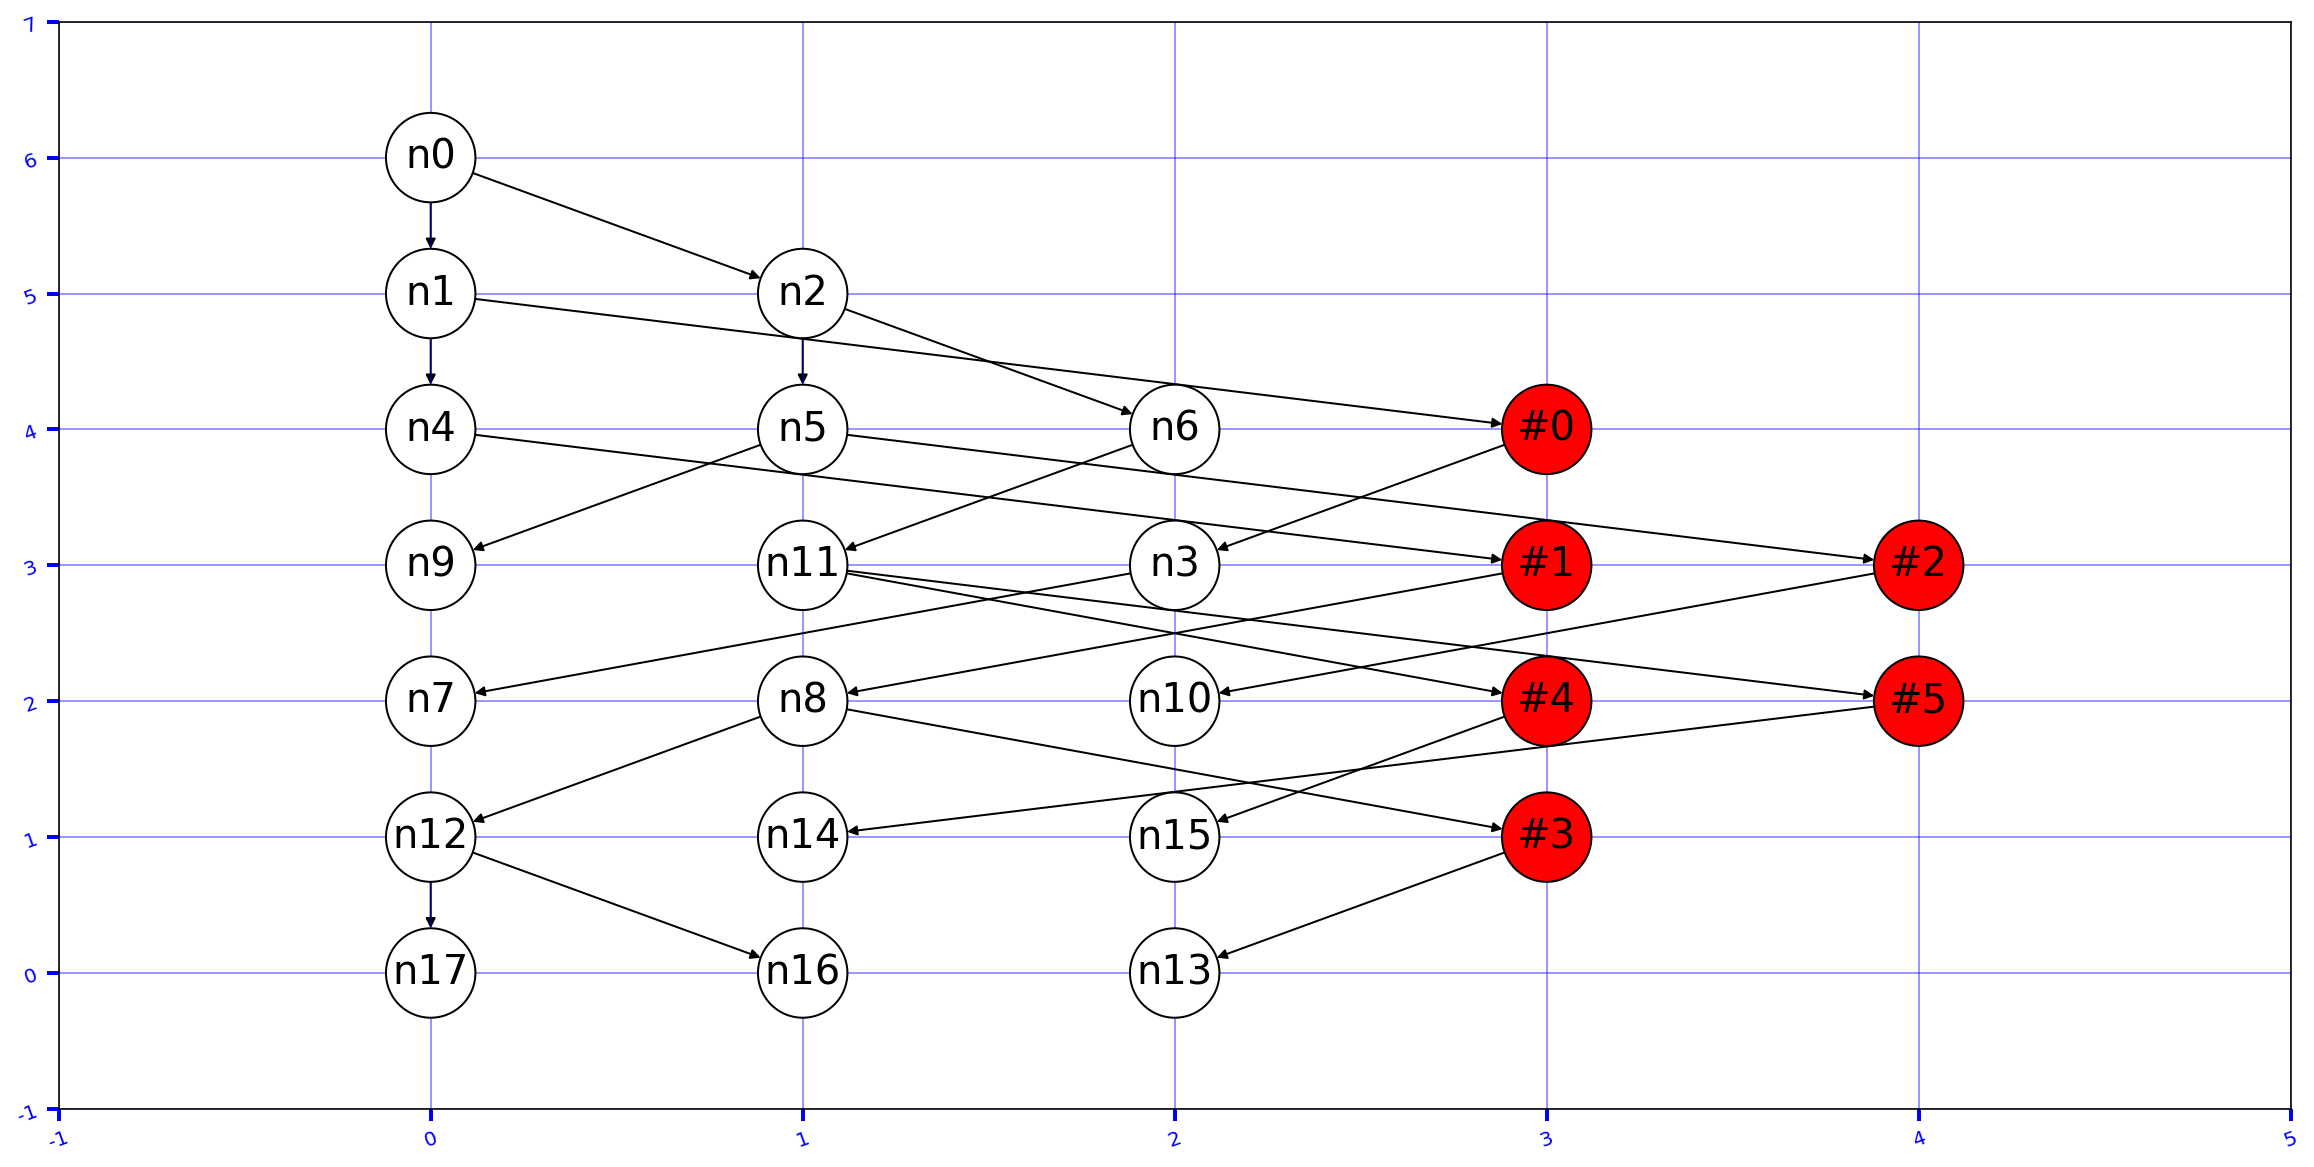

In [109]:
dag = nx.read_graphml('sample-data/binary_tree.xml')
CoffmanGrahamLayout()(dag, max_width=3)

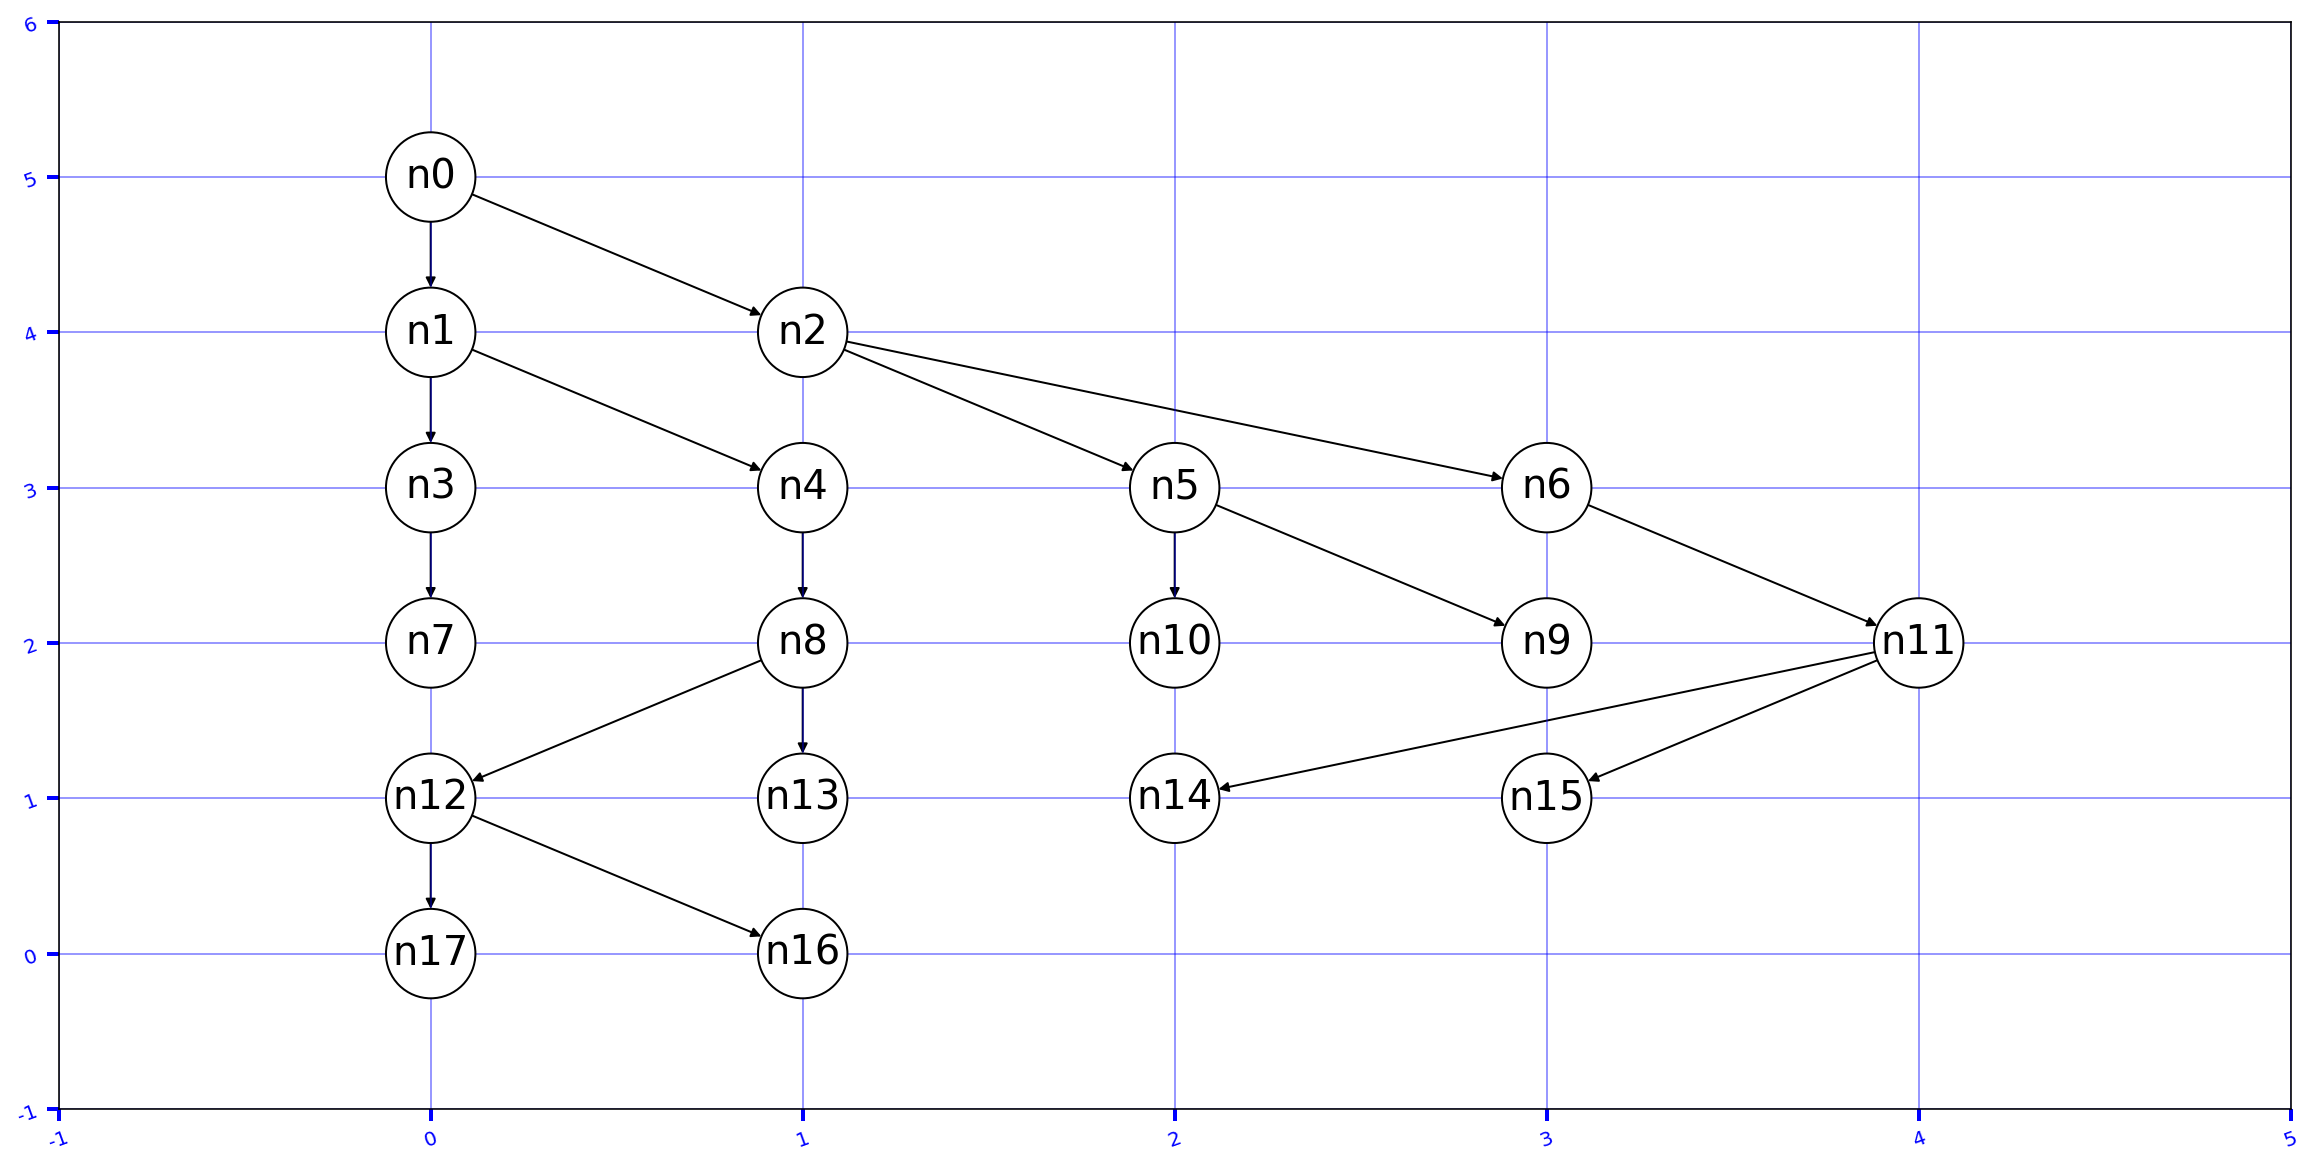

In [110]:
dag = nx.read_graphml('sample-data/binary_tree.xml')
CoffmanGrahamLayout()(dag, max_width=None)